import necessary packages

In [1]:
from MIR.models import SpatialTransformer, AffineReg3D
import nibabel as nib
from scipy.ndimage import zoom
import numpy as np
import torch
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


read in images

In [3]:
img_nib = nib.load('sub-032125_ses-001_run-1_T1w.nii.gz')
template_nib = nib.load('LUMIR_template.nii.gz')
original_affine = img_nib.affine.copy()
original_shape = img_nib.shape
original_pixdim = img_nib.header.structarr['pixdim'][1:-4]

reorient and resample the image if needed

In [4]:
def reorient_image_to_match(reference_nii, target_nii):
    reference_ornt = nib.aff2axcodes(reference_nii.affine)
    target_reoriented = nib.as_closest_canonical(target_nii, enforce_diag=False)
    target_ornt = nib.aff2axcodes(target_reoriented.affine)
    
    # If orientations don't match, perform reorientation
    if target_ornt != reference_ornt:
        # Calculate the transformation matrix to match the reference orientation
        ornt_trans = nib.orientations.ornt_transform(nib.io_orientation(target_reoriented.affine),
                                                     nib.io_orientation(reference_nii.affine))
        target_reoriented = target_reoriented.as_reoriented(ornt_trans)
    return target_reoriented

def resampling(img_npy, img_pixdim, tar_pixdim, order, mode='constant'):
    if order == 0:
        img_npy = img_npy.astype(np.uint16)
    img_npy = zoom(img_npy, ((img_pixdim[0] / tar_pixdim[0]), (img_pixdim[1] / tar_pixdim[1]), (img_pixdim[2] / tar_pixdim[2])), order=order, prefilter=False, mode=mode)
    return img_npy

img_nib = reorient_image_to_match(template_nib, img_nib)
affine_type = 'Affine'
affine_metric = 'meanSquares'
tar_pixdim = [1.0, 1.0, 1.0]  # Target pixel dimensions
img_pixdim = img_nib.header.structarr['pixdim'][1:-4]

img_npy = img_nib.get_fdata()
img_npy = resampling(img_npy, img_pixdim, tar_pixdim, order=2)
img_torch = torch.from_numpy(img_npy[np.newaxis, np.newaxis, ...]).float().cuda(0)
template_npy = template_nib.get_fdata()
template_torch = torch.from_numpy(template_npy[np.newaxis, np.newaxis, ...]).float().cuda(0)

affine registration - MSE first

[AffineReg3D] scale 1/2 step 1/50 loss=0.063391
[AffineReg3D] scale 1/2 step 10/50 loss=0.048361
[AffineReg3D] scale 1/2 step 20/50 loss=0.043646
[AffineReg3D] scale 1/2 step 30/50 loss=0.034076
[AffineReg3D] scale 1/2 step 40/50 loss=0.033672
[AffineReg3D] scale 1/2 step 50/50 loss=0.030975
[AffineReg3D] scale 2/2 step 1/50 loss=0.047239
[AffineReg3D] scale 2/2 step 10/50 loss=0.039049
[AffineReg3D] scale 2/2 step 20/50 loss=0.035217
[AffineReg3D] scale 2/2 step 30/50 loss=0.033528
[AffineReg3D] scale 2/2 step 40/50 loss=0.033494
[AffineReg3D] scale 2/2 step 50/50 loss=0.033333


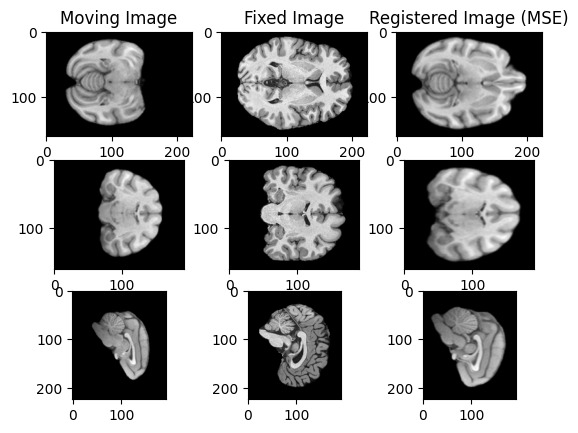

In [4]:
# "mse", "l1", "ncc", "fastncc", "pcc", "localcorrratio", "corrratio", "ssim3d", "mutualinformation", "localmutualinformation", "mind"
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("mse", "mse"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (MSE)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

MAE

[AffineReg3D] scale 1/2 step 1/50 loss=0.104449
[AffineReg3D] scale 1/2 step 10/50 loss=0.089661
[AffineReg3D] scale 1/2 step 20/50 loss=0.088117
[AffineReg3D] scale 1/2 step 30/50 loss=0.079798
[AffineReg3D] scale 1/2 step 40/50 loss=0.072244
[AffineReg3D] scale 1/2 step 50/50 loss=0.070769
[AffineReg3D] scale 2/2 step 1/50 loss=0.085838
[AffineReg3D] scale 2/2 step 10/50 loss=0.083387
[AffineReg3D] scale 2/2 step 20/50 loss=0.078796
[AffineReg3D] scale 2/2 step 30/50 loss=0.075951
[AffineReg3D] scale 2/2 step 40/50 loss=0.074360
[AffineReg3D] scale 2/2 step 50/50 loss=0.073855


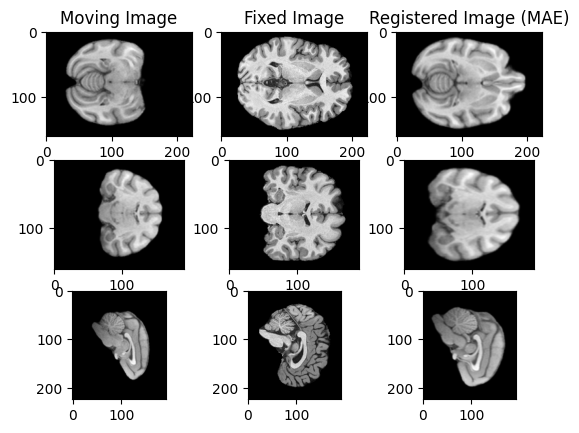

In [5]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("l1", "l1"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (MAE)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

NCC

[AffineReg3D] scale 1/2 step 1/50 loss=-0.030813
[AffineReg3D] scale 1/2 step 10/50 loss=-0.082650
[AffineReg3D] scale 1/2 step 20/50 loss=-0.084324
[AffineReg3D] scale 1/2 step 30/50 loss=-0.085671
[AffineReg3D] scale 1/2 step 40/50 loss=-0.102832
[AffineReg3D] scale 1/2 step 50/50 loss=-0.110011
[AffineReg3D] scale 2/2 step 1/50 loss=-0.045032
[AffineReg3D] scale 2/2 step 10/50 loss=-0.045032
[AffineReg3D] scale 2/2 step 20/50 loss=-0.045032
[AffineReg3D] scale 2/2 step 30/50 loss=-0.045032
[AffineReg3D] scale 2/2 step 40/50 loss=-0.045032
[AffineReg3D] scale 2/2 step 50/50 loss=-0.045032


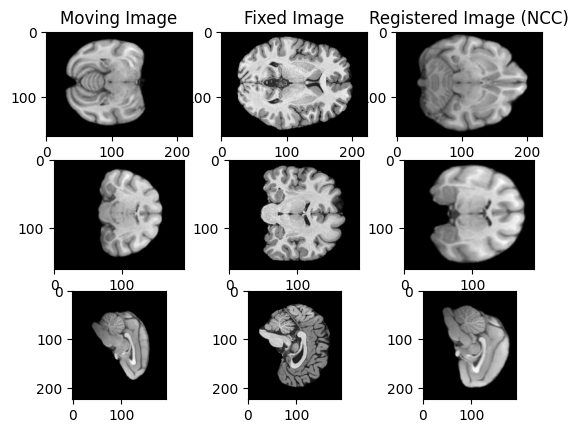

In [6]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("ncc", "ncc"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (NCC)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

Fast NCC

[AffineReg3D] scale 1/2 step 1/50 loss=-0.431877
[AffineReg3D] scale 1/2 step 10/50 loss=-0.669028
[AffineReg3D] scale 1/2 step 20/50 loss=-0.669028
[AffineReg3D] scale 1/2 step 30/50 loss=-0.669028
[AffineReg3D] scale 1/2 step 40/50 loss=-0.669028
[AffineReg3D] scale 1/2 step 50/50 loss=-0.669028
[AffineReg3D] scale 2/2 step 1/50 loss=-0.183254
[AffineReg3D] scale 2/2 step 10/50 loss=-1.192718
[AffineReg3D] scale 2/2 step 20/50 loss=-1.192718
[AffineReg3D] scale 2/2 step 30/50 loss=-1.192718
[AffineReg3D] scale 2/2 step 40/50 loss=-1.192718
[AffineReg3D] scale 2/2 step 50/50 loss=-1.192718


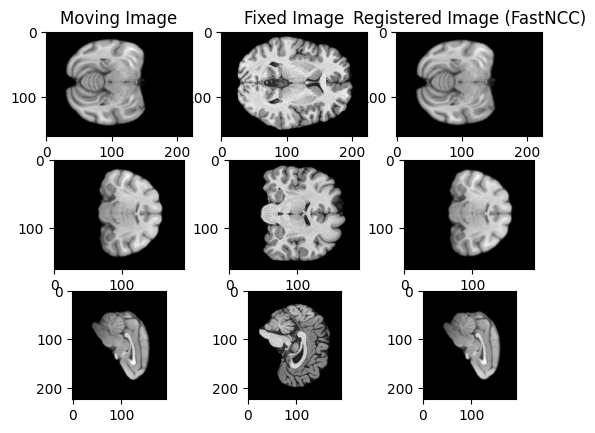

In [7]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("fastncc", "fastncc"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (FastNCC)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

PCC

[AffineReg3D] scale 1/2 step 1/50 loss=0.299713
[AffineReg3D] scale 1/2 step 10/50 loss=0.228416
[AffineReg3D] scale 1/2 step 20/50 loss=0.191761
[AffineReg3D] scale 1/2 step 30/50 loss=0.153095
[AffineReg3D] scale 1/2 step 40/50 loss=0.150745
[AffineReg3D] scale 1/2 step 50/50 loss=0.137881
[AffineReg3D] scale 2/2 step 1/50 loss=0.206475
[AffineReg3D] scale 2/2 step 10/50 loss=0.193067
[AffineReg3D] scale 2/2 step 20/50 loss=0.178036
[AffineReg3D] scale 2/2 step 30/50 loss=0.169742
[AffineReg3D] scale 2/2 step 40/50 loss=0.151606
[AffineReg3D] scale 2/2 step 50/50 loss=0.148692


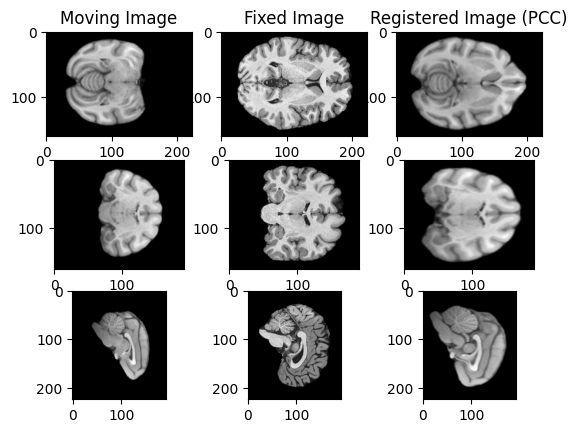

In [8]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("pcc", "pcc"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (PCC)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

Local Correlation Ratio

[AffineReg3D] scale 1/2 step 1/50 loss=-0.012681
[AffineReg3D] scale 1/2 step 10/50 loss=-0.031289
[AffineReg3D] scale 1/2 step 20/50 loss=-0.031703
[AffineReg3D] scale 1/2 step 30/50 loss=-0.031853
[AffineReg3D] scale 1/2 step 40/50 loss=-0.035647
[AffineReg3D] scale 1/2 step 50/50 loss=-0.039602
[AffineReg3D] scale 2/2 step 1/50 loss=-0.018809
[AffineReg3D] scale 2/2 step 10/50 loss=-0.020604
[AffineReg3D] scale 2/2 step 20/50 loss=-0.021159
[AffineReg3D] scale 2/2 step 30/50 loss=-0.021389
[AffineReg3D] scale 2/2 step 40/50 loss=-0.021498
[AffineReg3D] scale 2/2 step 50/50 loss=-0.021503


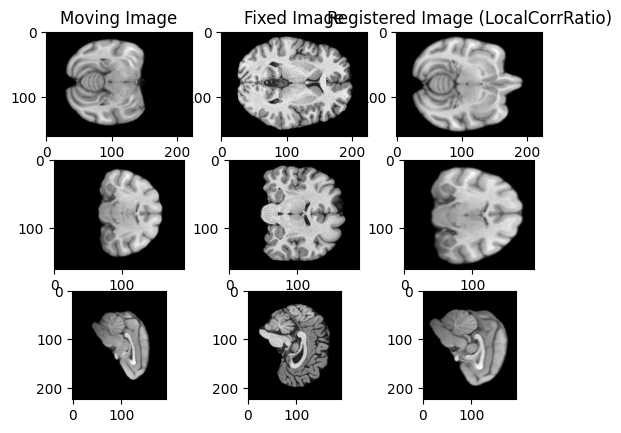

In [9]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("localcorrratio", "localcorrratio"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (LocalCorrRatio)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

Correlation Ratio

[AffineReg3D] scale 1/2 step 1/50 loss=-0.194105
[AffineReg3D] scale 1/2 step 10/50 loss=-0.232355
[AffineReg3D] scale 1/2 step 20/50 loss=-0.249218
[AffineReg3D] scale 1/2 step 30/50 loss=-0.270767
[AffineReg3D] scale 1/2 step 40/50 loss=-0.274612
[AffineReg3D] scale 1/2 step 50/50 loss=-0.280749
[AffineReg3D] scale 2/2 step 1/50 loss=-0.245108
[AffineReg3D] scale 2/2 step 10/50 loss=-0.264587
[AffineReg3D] scale 2/2 step 20/50 loss=-0.268779
[AffineReg3D] scale 2/2 step 30/50 loss=-0.268873
[AffineReg3D] scale 2/2 step 40/50 loss=-0.268902
[AffineReg3D] scale 2/2 step 50/50 loss=-0.268942


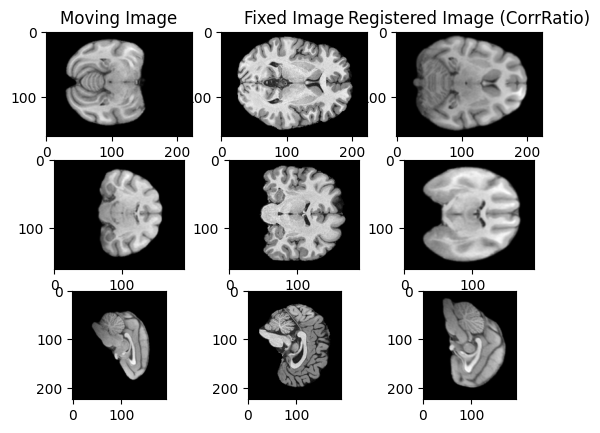

In [10]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("corrratio", "corrratio"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (CorrRatio)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

SSIM

[AffineReg3D] scale 1/2 step 1/50 loss=0.339420
[AffineReg3D] scale 1/2 step 10/50 loss=0.317893
[AffineReg3D] scale 1/2 step 20/50 loss=0.307726
[AffineReg3D] scale 1/2 step 30/50 loss=0.307205
[AffineReg3D] scale 1/2 step 40/50 loss=0.304419
[AffineReg3D] scale 1/2 step 50/50 loss=0.302608
[AffineReg3D] scale 2/2 step 1/50 loss=0.280778
[AffineReg3D] scale 2/2 step 10/50 loss=0.276584
[AffineReg3D] scale 2/2 step 20/50 loss=0.275671
[AffineReg3D] scale 2/2 step 30/50 loss=0.275593
[AffineReg3D] scale 2/2 step 40/50 loss=0.275511
[AffineReg3D] scale 2/2 step 50/50 loss=0.275476


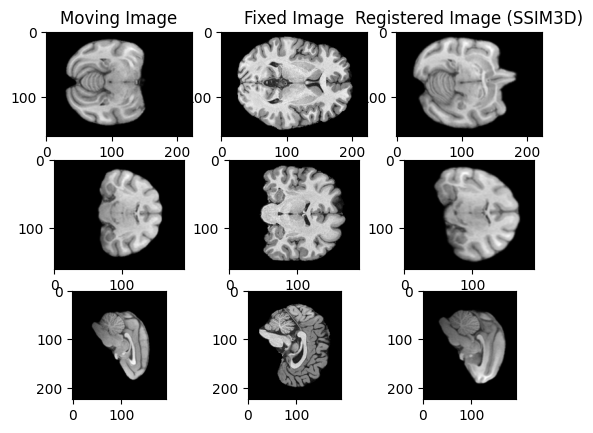

In [11]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("ssim3d", "ssim3d"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (SSIM3D)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

Local Mutual Information

[AffineReg3D] scale 1/2 step 1/50 loss=-0.028006
[AffineReg3D] scale 1/2 step 10/50 loss=-0.048122
[AffineReg3D] scale 1/2 step 20/50 loss=-0.048834
[AffineReg3D] scale 1/2 step 30/50 loss=-0.049079
[AffineReg3D] scale 1/2 step 40/50 loss=-0.051555
[AffineReg3D] scale 1/2 step 50/50 loss=-0.056551
[AffineReg3D] scale 2/2 step 1/50 loss=-0.032026
[AffineReg3D] scale 2/2 step 10/50 loss=-0.034772
[AffineReg3D] scale 2/2 step 20/50 loss=-0.034960
[AffineReg3D] scale 2/2 step 30/50 loss=-0.034994
[AffineReg3D] scale 2/2 step 40/50 loss=-0.035001
[AffineReg3D] scale 2/2 step 50/50 loss=-0.035033


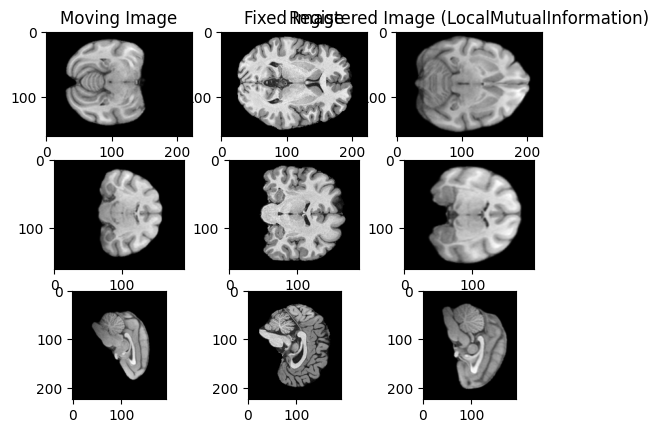

In [12]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("localmutualinformation", "localmutualinformation"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (LocalMutualInformation)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

Mutual Information

[AffineReg3D] scale 1/2 step 1/50 loss=-0.245438
[AffineReg3D] scale 1/2 step 10/50 loss=-0.319081
[AffineReg3D] scale 1/2 step 20/50 loss=-0.337679
[AffineReg3D] scale 1/2 step 30/50 loss=-0.354218
[AffineReg3D] scale 1/2 step 40/50 loss=-0.403956
[AffineReg3D] scale 1/2 step 50/50 loss=-0.409372
[AffineReg3D] scale 2/2 step 1/50 loss=-0.335809
[AffineReg3D] scale 2/2 step 10/50 loss=-0.394356
[AffineReg3D] scale 2/2 step 20/50 loss=-0.400827
[AffineReg3D] scale 2/2 step 30/50 loss=-0.403455
[AffineReg3D] scale 2/2 step 40/50 loss=-0.403580
[AffineReg3D] scale 2/2 step 50/50 loss=-0.403671


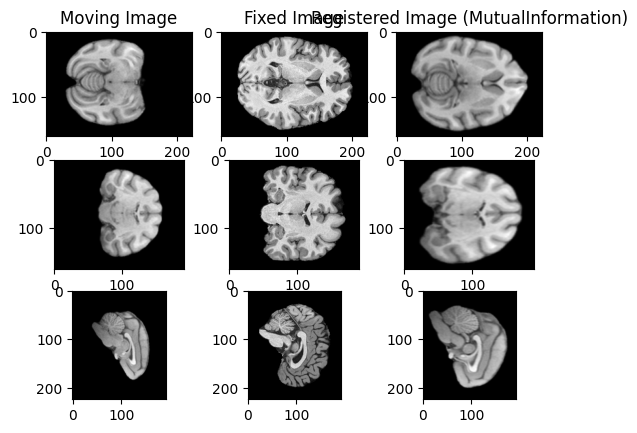

In [5]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("mutualinformation", "mutualinformation"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (MutualInformation)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()

MIND

[AffineReg3D] scale 1/2 step 1/50 loss=0.091595
[AffineReg3D] scale 1/2 step 10/50 loss=0.071328
[AffineReg3D] scale 1/2 step 20/50 loss=0.070432
[AffineReg3D] scale 1/2 step 30/50 loss=0.066786
[AffineReg3D] scale 1/2 step 40/50 loss=0.059672
[AffineReg3D] scale 1/2 step 50/50 loss=0.059215
[AffineReg3D] scale 2/2 step 1/50 loss=0.067363
[AffineReg3D] scale 2/2 step 10/50 loss=0.066355
[AffineReg3D] scale 2/2 step 20/50 loss=0.063970
[AffineReg3D] scale 2/2 step 30/50 loss=0.063140
[AffineReg3D] scale 2/2 step 40/50 loss=0.063071
[AffineReg3D] scale 2/2 step 50/50 loss=0.063006


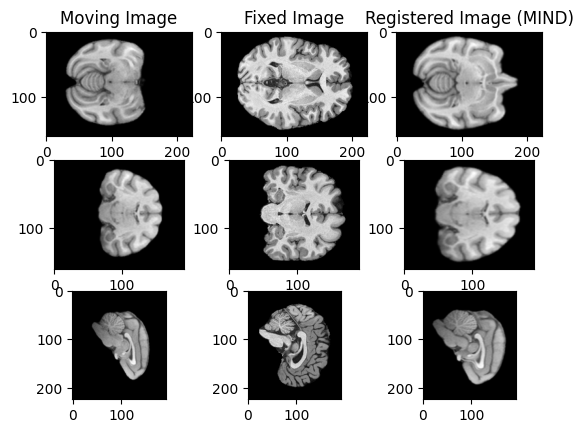

In [6]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("mind", "mind"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(3, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(3, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image (MIND)')
plt.subplot(3, 3, 4)
plt.imshow(img_torch[0, 0, :, img_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(template_torch[0, 0, :, template_torch.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(output[0, 0, :, output.shape[3] // 2, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(img_torch[0, 0, img_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(template_torch[0, 0, template_torch.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(output[0, 0, output.shape[2] // 2, :, :].detach().cpu().numpy(), cmap='gray')
plt.show()